

# Computational Graph

Sorix constructs a **directed acyclic computational graph (DAG)** that records every operation applied to tensors created with the parameter `requires_grad=True`. In this graph, each node represents an **elementary operation**—such as addition, multiplication, exponentiation, or matrix multiplication—while the edges represent the **tensors** flowing between those operations.

This mechanism allows Sorix to capture the complete functional dependency between the input variables and all intermediate expressions. Every time an operation is executed (e.g., `x + y`, `x * y`, `x**2`), Sorix creates a new node in the graph and connects it to the nodes corresponding to the operands involved in the computation.

As a result:

* The graph encodes the **exact sequence of algebraic transformations** performed.
* It preserves the **structural dependencies** among all tensors participating in the computation.
* It grows dynamically **only** when `requires_grad=True`, avoiding unnecessary overhead when [automatic differentiation](../autograd) is not required.


## Example

In [96]:
from sorix import tensor

Defining functions to plot

In [108]:
from graphviz import Digraph

def trace_graph(root):
    ops = {}
    edges = []

    def build(t):
        tid = id(t)

        if t._op and tid not in ops:
            ops[tid] = t

        for child in t._prev:
            edges.append((child, t))
            build(child)

    build(root)
    return ops, edges


def tensor_label(t):
    arr = t.to_numpy() if hasattr(t, "to_numpy") else t.data
    if arr.ndim == 0:
        return str(arr.item())
    if arr.size <= 6:
        return str(arr.tolist())
    return f"{arr.shape}"


def draw_graph_ops_forward(root, filename="graph_ops", view=True):
    dot = Digraph(format="png", graph_attr={"rankdir": "LR"})

    ops, edges = trace_graph(root)

    for op_id, tensor_obj in ops.items():
        label = tensor_obj._op
        dot.node(str(op_id), label, shape="circle",
                 style="filled", color="#F7DC6F")

    for parent_tensor, child_tensor in edges:
        label = tensor_label(parent_tensor)

        edge_color = "green" if parent_tensor.requires_grad else "#888888"

        if parent_tensor._op:
            parent_node = str(id(parent_tensor))
        else:
            parent_node = f"INPUT_{id(parent_tensor)}"
            dot.node(parent_node, "", shape="point", width="0.1")


        child_node = str(id(child_tensor))

        dot.edge(parent_node, child_node,
                 label=f'data={label}', color=edge_color)

    final_label = tensor_label(root)
    final_color = "green" if root.requires_grad else "#888888"

    final_node = f"FINAL_{id(root)}"
    dot.node(final_node, "", shape="point", width="0.1")

    if root._op:
        dot.edge(str(id(root)), final_node,
                 label=final_label, color=final_color)

    dot.render(filename, view=view)
    return dot


def gradient_label(t):
    """Muestra el gradiente del tensor en lugar de su valor"""
    if t.grad is None:
        return "grad=None"
    

    if hasattr(t.grad, "to_numpy"):
        grad_arr = t.grad.to_numpy()
    elif hasattr(t.grad, "data"):
        grad_arr = np.array(t.grad.data)
    else:
        grad_arr = np.array(t.grad)
    
    if grad_arr.ndim == 0:
        return f"grad={grad_arr.item():.4f}"
    if grad_arr.size <= 6:

        grad_list = grad_arr.tolist()
        if isinstance(grad_list, list):
            grad_list = [round(x, 4) if isinstance(x, float) else x for x in grad_list]
        return f"grad={grad_list}"
    return f"grad.shape={grad_arr.shape}"

def draw_graph_ops_backward(root, filename="graph_ops", view=True):
    dot = Digraph(format="png", graph_attr={"rankdir": "RL"})
    ops, edges = trace_graph(root)
    

    for op_id, tensor_obj in ops.items():
        label = tensor_obj._op
        dot.node(str(op_id), label, shape="circle",
                 style="filled", color="#F7DC6F")
    

    for parent_tensor, child_tensor in edges:
        label = gradient_label(parent_tensor)
        

        edge_color = "green" if parent_tensor.grad is not None else "#888888"
        

        child_node = str(id(child_tensor))
        

        if parent_tensor._op:
            parent_node = str(id(parent_tensor))
        else:
            parent_node = f"INPUT_{id(parent_tensor)}"
            dot.node(parent_node, "", shape="point", width="0.1")
        

        dot.edge(child_node, parent_node,
                 label=label, color=edge_color)
    

    final_label = gradient_label(root)
    final_color = "green" if root.grad is not None else "#888888"
    final_node = f"FINAL_{id(root)}"
    dot.node(final_node, "", shape="point", width="0.1")
    
    if root._op:

        dot.edge(final_node, str(id(root)),
                 label=final_label, color=final_color)
    
    dot.render(filename, view=view)
    return dot

## The computational graph of $f(x,y) = x^2 + y^2$

Where:
- x = 3
- y = 4

### Foward

Sorix creates a computational graph

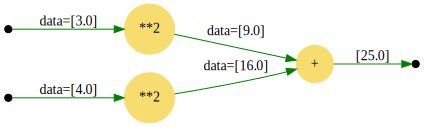

In [112]:
x = tensor([3.0], requires_grad=True)
y = tensor([4.0], requires_grad=True)

f = x**2 + y**2

draw_graph_ops_forward(f, "graph_ops", view=False)



### Backward

When `f_output.backward()` is executed, Sorix traverses the previously constructed computational graph and applies the chain rule to compute all required derivatives. The resulting partial derivatives are written into the **`.grad`** attribute of the input Tensors $x$ and $y$.

* $ \frac{\partial f}{\partial x} = 2x = 6.0 $
* $ \frac{\partial f}{\partial y} = 2y = 8.0 $

In [118]:
f.backward()
print(f"df/dx: {x.grad}")
print(f"df/dy: {y.grad}")

df/dx: [60.]
df/dy: [80.]


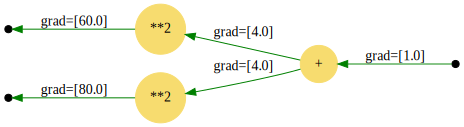

In [119]:
draw_graph_ops_backward(f, "graph_ops", view=False)


In summary, the computational graph is the structural foundation that enables Sorix to perform **precise, efficient, and fully automatic differentiation** without requiring any manual derivation of gradients.